### Tarea 4 Deep Learning

#### Integrantes:
* Elisa Parga
* Nicolás Fierro

En esta tarea van a crear una red neuronal que clasifique mensajes como spam o no spam. Lo primero es descargar la data:

In [ ]:
!wget https://www.ivan-sipiran.com/downloads/spam.csv

--2022-12-06 02:19:52--  https://www.ivan-sipiran.com/downloads/spam.csv
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471781 (461K)
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 460.72K  --.-KB/s    in 0.1s    

2022-12-06 02:19:52 (3.54 MB/s) - ‘spam.csv’ saved [471781/471781]



Los datos vienen en un archivo CSV que contiene dos columnas "text" y "label". La columna "text" contiene el texto del mensaje y la columna "label" contiene las etiquetas "ham" y "spam". Un mensaje "ham" es un mensaje que no se considera spam.

# Tarea 
El objetivo de la tarea es crear una red neuronal que clasifique los datos entregados. Para lograr esto debes:



*   Implementar el pre-procesamiento de los datos que creas necesario.
*   Particionar los datos en 70% entrenamiento, 10% validación y 20% test.
*   Usa los datos de entrenamiento y valiadación para tus experimentos y sólo usa el conjunto de test para reportar el resultado final.

Para el diseño de la red neuronal puedes usar una red neuronal recurrente o una red basada en transformers. El objetivo de la tarea no es obtener el performance ultra máximo, sino entender qué decisiones de diseño afectan la solución de un problema como este. Lo que si es necesario (como siempre) es que discutas los resultados y decisiones realizadas.



Importamos las librerías necesarias:

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import time

### Pre-procesamiento:
Usamos los dataframes de pandas para cargar el dataset:

In [ ]:
spam = pd.read_csv('/content/spam.csv')
spam

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [ ]:
spam.dtypes

text     object
label    object
dtype: object

### Limpieza texto:

Creamos una función que elimina los puntos y los saltos de línea para limpiar los emails.

In [ ]:
def clear_text(texto):
  '''Elimina la puntuación y saltos de línea en un texto dado'''
  texto = str(texto).lower()
  no_punctuation = ''.join([c for c in texto if c not in punctuation])
  text_split = no_punctuation.split('\n')
  clean_text = ''.join(text_split)
  return clean_text

Aplicamos la función de limpieza a todos los mails de nuestro dataset.

In [ ]:
spam['text'] = spam['text'].apply(clear_text)
spam

,text,label
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i dont think he goes to usf he lives aroun...,ham
...,...,...
5567,this is the 2nd time we have tried 2 contact u...,spam
5568,will ì b going to esplanade fr home,ham
5569,pity was in mood for that soany other suggest...,ham
5570,the guy did some bitching but i acted like id ...,ham


### Codificación de palabras:

Codificamos las palabras uniendo todos los mails y luego usando la clase Counter para contar la ocurrencia de cada palabra, con esto construímos un vocabulario.

In [ ]:
# unir todo el texto 
all_mails = spam['text'].str.cat(sep=' ')

# split de las palabras
all_words = all_mails.split()

In [ ]:
# contar las palabras
count_words = Counter(all_words)

# ordenar palabras según frecuencia y retornar lista de palabras
vocabulary = sorted(count_words, key=count_words.get, reverse=True)

# se construye un diccionario para mapear la palabra al número entero
vocab_to_int = {word: i for i, word in enumerate(vocabulary, 1)}


In [ ]:
print('Counter de palabras:')
print(count_words)
print('\n')
print('Vocabulario de palabras ordenado según frecuencia:')
print(vocabulary)
print('\n')
print('Diccionario de vocabulario con índices:')
print(vocab_to_int)

Counter de palabras:
Counter({'to': 2204, 'i': 2198, 'you': 2098, 'a': 1417, 'the': 1300, 'u': 1097, 'and': 956, 'in': 868, 'is': 864, 'me': 772, 'my': 737, 'for': 693, 'your': 668, 'of': 607, 'it': 602, 'call': 571, 'have': 563, 'on': 530, 'that': 501, 'are': 483, 'now': 474, '2': 473, 'im': 460, 'so': 425, 'not': 418, 'but': 418, 'or': 405, 'can': 401, 'at': 396, 'do': 396, 'ur': 379, 'with': 378, 'be': 378, 'get': 377, 'will': 372, 'if': 365, 'just': 362, 'we': 339, 'no': 325, 'this': 325, 'up': 300, 'its': 299, '4': 286, 'when': 284, 'go': 275, 'from': 275, 'free': 274, 'ok': 272, 'dont': 266, 'all': 264, 'out': 263, 'how': 260, 'what': 257, 'know': 254, 'like': 237, 'got': 236, 'ill': 234, 'then': 229, 'good': 227, 'was': 226, 'come': 223, 'am': 217, 'time': 208, 'only': 207, 'day': 197, 'there': 195, 'want': 191, 'love': 191, 'text': 188, 'send': 188, 'he': 181, 'as': 179, 'going': 170, 'one': 168, 'by': 166, 'about': 164, 'need': 164, 'txt': 163, 'lor': 160, 'home': 159, 'lt': 1

In [ ]:
print('Tamaño del vocabulario:', len(vocab_to_int))

Tamaño del vocabulario: 9397


Escribimos cada mail como una lista de tokens según el diccionario creado previamente y agregamos una columna al dataframe con los mails tokenizados:

In [ ]:
# tokenizamos cada mail del dataframe y lo guardamos en una columna
def tokenizer(mail, vocabulary_dict):
  '''tokeniza un mail ya limpio (sin puntuación, ni saltos de línea, ni uppercase)'''
  tokenized_mail = []
  mail_split = mail.split() # separamos el mail por palabra
  for word in mail_split:
    tokenized_mail.append(vocabulary_dict[word])
  return tokenized_mail

In [ ]:
# agregamos una columna al dataframe con los mails tokenizados (embedding de las palabras)
spam['tokenized_mails'] = spam['text'].apply(lambda mail: tokenizer(mail, vocab_to_int))
spam

,text,label,tokenized_mails
0,go until jurong point crazy available only in ...,ham,"[45, 447, 4303, 786, 704, 670, 64, 8, 1230, 89..."
1,ok lar joking wif u oni,ham,"[48, 307, 1384, 431, 6, 1809]"
2,free entry in 2 a wkly comp to win fa cup fina...,spam,"[47, 448, 8, 22, 4, 745, 891, 1, 179, 1810, 11..."
3,u dun say so early hor u c already then say,ham,"[6, 228, 146, 24, 351, 2854, 6, 160, 143, 58, ..."
4,nah i dont think he goes to usf he lives aroun...,ham,"[945, 2, 49, 97, 71, 449, 1, 892, 71, 1813, 20..."
...,...,...,...
5567,this is the 2nd time we have tried 2 contact u...,spam,"[40, 9, 5, 393, 63, 38, 17, 522, 22, 188, 6, 6..."
5568,will ì b going to esplanade fr home,ham,"[35, 110, 195, 73, 1, 1908, 862, 80]"
5569,pity was in mood for that soany other suggest...,ham,"[9394, 60, 8, 1226, 12, 19, 9395, 231, 9396]"
5570,the guy did some bitching but i acted like id ...,ham,"[5, 519, 108, 109, 9397, 26, 2, 4244, 55, 391,..."


De manera similar, agregamos una columna con los embedding de los labels. Se le atribuye el valor de 1 a la etiquieta *spam* y el valor 0 a *ham*:

In [ ]:
spam['tokenized_label'] = spam['label'].apply(lambda label: 1 if label == 'spam' else 0)
spam

,text,label,tokenized_mails,tokenized_label
0,go until jurong point crazy available only in ...,ham,"[45, 447, 4303, 786, 704, 670, 64, 8, 1230, 89...",0
1,ok lar joking wif u oni,ham,"[48, 307, 1384, 431, 6, 1809]",0
2,free entry in 2 a wkly comp to win fa cup fina...,spam,"[47, 448, 8, 22, 4, 745, 891, 1, 179, 1810, 11...",1
3,u dun say so early hor u c already then say,ham,"[6, 228, 146, 24, 351, 2854, 6, 160, 143, 58, ...",0
4,nah i dont think he goes to usf he lives aroun...,ham,"[945, 2, 49, 97, 71, 449, 1, 892, 71, 1813, 20...",0
...,...,...,...,...
5567,this is the 2nd time we have tried 2 contact u...,spam,"[40, 9, 5, 393, 63, 38, 17, 522, 22, 188, 6, 6...",1
5568,will ì b going to esplanade fr home,ham,"[35, 110, 195, 73, 1, 1908, 862, 80]",0
5569,pity was in mood for that soany other suggest...,ham,"[9394, 60, 8, 1226, 12, 19, 9395, 231, 9396]",0
5570,the guy did some bitching but i acted like id ...,ham,"[5, 519, 108, 109, 9397, 26, 2, 4244, 55, 391,...",0


### Filtro mails sin contenido:

Verificamos que todos los mails tengan contenido obteniendo el largo de la lista de tokens y eliminamos los mails que no tienen.

In [ ]:
# verificamos la longitud de cada mail
mail_lens = Counter(len(x) for x in spam['tokenized_mails'])
print("Mails de longitud cero:", mail_lens[0])
print('Máxima longitud:', max(mail_lens))

Mails de longitud cero: 2
Máxima longitud: 171


In [ ]:
# examinamos los mails que no tienen contenido
no_content = spam.loc[spam['tokenized_mails'].apply(lambda x: len(x) == 0)]
no_content

,text,label,tokenized_mails,tokenized_label
3374,,ham,[],0
4822,,ham,[],0


In [ ]:
spam.drop(no_content.index.tolist(), axis=0, inplace=True)
spam

,text,label,tokenized_mails,tokenized_label
0,go until jurong point crazy available only in ...,ham,"[45, 447, 4303, 786, 704, 670, 64, 8, 1230, 89...",0
1,ok lar joking wif u oni,ham,"[48, 307, 1384, 431, 6, 1809]",0
2,free entry in 2 a wkly comp to win fa cup fina...,spam,"[47, 448, 8, 22, 4, 745, 891, 1, 179, 1810, 11...",1
3,u dun say so early hor u c already then say,ham,"[6, 228, 146, 24, 351, 2854, 6, 160, 143, 58, ...",0
4,nah i dont think he goes to usf he lives aroun...,ham,"[945, 2, 49, 97, 71, 449, 1, 892, 71, 1813, 20...",0
...,...,...,...,...
5567,this is the 2nd time we have tried 2 contact u...,spam,"[40, 9, 5, 393, 63, 38, 17, 522, 22, 188, 6, 6...",1
5568,will ì b going to esplanade fr home,ham,"[35, 110, 195, 73, 1, 1908, 862, 80]",0
5569,pity was in mood for that soany other suggest...,ham,"[9394, 60, 8, 1226, 12, 19, 9395, 231, 9396]",0
5570,the guy did some bitching but i acted like id ...,ham,"[5, 519, 108, 109, 9397, 26, 2, 4244, 55, 391,...",0


### Padding:

Definimos una función para agregar paddings a los mails que sean más cortos que el largo definido. De esta forma podemos entrenar una red para secuencias del mismo largo. Los ceros del padding se agregan al inicio de la lista de tokens de forma que no se desvanezca el vector característico (último vector oculto). Aplicamos esta función a la columna de *tokenized_mails* y guardamos sus valores en una nueva columna *mails_pad*

In [ ]:
def padding_mails(tokenized_mail, max_length):
  tokenized_mail = np.array(tokenized_mail)
  diff = max_length - len(tokenized_mail)
  if diff > 0:
    pad = np.zeros(diff)
    mail_pad = np.concatenate((pad, tokenized_mail))
    return mail_pad
  elif diff == 0:
    return tokenized_mail

Seleccionamos 171 como longitud máxima para los mails debido a que el mail más extenso tiene 171 palabras.

In [ ]:
spam['mails_pad'] = spam['tokenized_mails'].apply(lambda x: padding_mails(x, 171))
spam

,text,label,tokenized_mails,tokenized_label,mails_pad
0,go until jurong point crazy available only in ...,ham,"[45, 447, 4303, 786, 704, 670, 64, 8, 1230, 89...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,ok lar joking wif u oni,ham,"[48, 307, 1384, 431, 6, 1809]",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,free entry in 2 a wkly comp to win fa cup fina...,spam,"[47, 448, 8, 22, 4, 745, 891, 1, 179, 1810, 11...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,u dun say so early hor u c already then say,ham,"[6, 228, 146, 24, 351, 2854, 6, 160, 143, 58, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,nah i dont think he goes to usf he lives aroun...,ham,"[945, 2, 49, 97, 71, 449, 1, 892, 71, 1813, 20...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
5567,this is the 2nd time we have tried 2 contact u...,spam,"[40, 9, 5, 393, 63, 38, 17, 522, 22, 188, 6, 6...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5568,will ì b going to esplanade fr home,ham,"[35, 110, 195, 73, 1, 1908, 862, 80]",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5569,pity was in mood for that soany other suggest...,ham,"[9394, 60, 8, 1226, 12, 19, 9395, 231, 9396]",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5570,the guy did some bitching but i acted like id ...,ham,"[5, 519, 108, 109, 9397, 26, 2, 4244, 55, 391,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### DataSets y DataLoaders:

Ahora nuestro dataset esta listo para ser procesado, tenemos la representación de todos los mails y sus labels en tokens. Creamos una función que genera una matriz a partir de una selección de columnas del dataframe (en este caso *tokenized_label* y *mails_pad*) con el objetivo de crear más facilmente los datasets de pytorch. Atribuímos el 70% del dataset para entrenamiento, 10% para validación y 30% para test.

In [ ]:
# creamos función para pasar de un dataframe a una matriz en numpy (necesario para crear pytorch datasets y dataloaders)
def create_matrix(column_dataframe, width):
  matrix = []
  for i in column_dataframe.index:
    row = column_dataframe[i]
    matrix.append(row)
  return np.array(matrix, dtype=int)

Si dividimos el dataset en exactamente en 70% entrenamiento, 10% validación y 30% test, la cantidad de elementos por cada conjunto de datos es respectivamente: 3898, 557 y 1115.

Al ver la cantidad de elementos que debe poseer cada set de datos notamos que no se pueden dividir en batches del mismo tamaño (los sets de validación y entrenamiento), pues el último batch de cada set no sería del tamaño indicado (`batch_size`) y PyTorch no permite tratarlo si está "incompleto". La opción que sugiere PyTorch es eliminar el último batch (cuando no alcanzamos a completar uno entero) por lo que es posible que se pierda información relevante.

Debido a esta dificultad para encontrar la partición adecuada tanto para el dataset de entrenamiento como de validación, se decide pasar 3 elementos del dataset de entrenamiento al dataset de validación de modo que queden con 3895 y 560 elementos respectivamente y se haga más fácil definir un tamaño de batch para cada uno.

In [ ]:
train_length = int(spam.shape[0]*0.7)
val_length = int(spam.shape[0]*0.1)

train_x, remaining_x = create_matrix(spam['mails_pad'].iloc[:3895], 171), create_matrix(spam['mails_pad'].iloc[3895:], 171)
train_y, remaining_y = spam['tokenized_label'].iloc[:3895].to_numpy(), spam['tokenized_label'].iloc[3895:].to_numpy()

val_x, test_x = remaining_x[:560], remaining_x[560:]
val_y, test_y = remaining_y[:560], remaining_y[560:]

print("\t\t\tFeatures:")
print("Train set: \t\t{}".format(train_x.shape[0]),
      "\nValidation set: \t{}".format(val_x.shape[0]),
      "\nTest set: \t\t{}".format(test_x.shape[0]))

			Features:
Train set: 		3895 
Validation set: 	560 
Test set: 		1115


Pasamos las matrices definidas anteriormente a datasets y dataloaders de pytorch. Se definen `batch_size` diferentes para `train_loader`, `valid_loader` y `test_loader`.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# crear Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_data, shuffle=True, batch_size=95) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=56)
test_loader = DataLoader(test_data, shuffle=False, batch_size=223)

### Arquitectura RNN:

Creamos una clase *SpamRNN* para definir una red neuronal para procesar secuencias con arquitectura LSTM. Esta clase tiene los siguientes parámetros:

* `vocab_size`: representa la cantidad de palabras que existen en nuestro dataset.
* `output_size`: tamaño de la salida de nuestra red, es igual a 1 en nuestro caso, pues los labels son de 1 dimension.
* `embedding_dim`: tamaño de los embeddings con los que vamos a representar nuestras palabras (tokens).
* `hidden_dim`: tamaño de los vectores ocultos de nuestra red recurrente.
* `n_layers`: número de capas de la red LSTM.
* `drop_prob`: probabilidad de dropout para todas las capas LSTM (incluso la última, este dropout se agrega manualmente).

La arquitectura de la red es la siguiente:

1. Una capa de embedding donde se convierten los tokens de palabras en embeddings del tamaño indicado. El output de esta capa es una matriz de dimensión $n_{tokens} \times {dim}_{embedding}$.
2. Un bloque de arquitectura LSTM definida por el tamaño de los hidden vectors y el número de capas. El output de este bloque es una tupla de dos elementos. El primero es un tensor que contiene todos los vectores ocultos de la última capa (todos los $h_t$). El segundo es una tupla de dimension 2 que contiene un tensor que tiene el último estado oculto para cada elemento de la secuencia y otro tensor con los últimos estados de las celdas de memoria para cada elemento de la secuencia. Para nuestro modelo, solo tomamos el último vector oculto (en la función `forward()`) 
3. Una capa fully-conneceted que pasa la salida del bloque LSTM a el tamaño de salida deseado (en este caso 1).
4. Una capa de activación sigmoide que convierte la salida a valores 0-1 para clasificar el texto.

In [ ]:
import torch.nn as nn
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

class SpamRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5): # vocab_size = cantidad de palabras
        
        super(SpamRNN, self).__init__()

        self.output_size = output_size # tamaño de la salida
        self.n_layers = n_layers # numero de capas
        self.hidden_dim = hidden_dim # tamaño de los vectores ocultos
        
        # Capas embedding y LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # tabla que guarda embedding de palabras de un diccionario (vocab_int)
        # yo decido cuan cuántos números representar una palabra
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        
        # dropout
        self.dropout = nn.Dropout(drop_prob) # en cada tiempo es como una red lineal, el dropout se aplica sobre los valores que toma h(t+1)
        
        # Capa lineal y sigmoide
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
                
        #Tomamos solo el último valor de salida del LSTM
        lstm_out = lstm_out[:,-1,:] # primera dimension es la dimension de los batches (los tomo todos), luego cel tamaño de la secuencia (tomo la última), y luego las
                                    # dimensiones de los hidden vectors
                
        # dropout y fully-connected
        out = self.dropout(lstm_out)
        out = self.fc(out)
               
        # sigmoide
        sig_out = self.sig(out)
                  
        # retornar sigmoide y último estado oculto
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        # Crea dos nuevos tensores con tamaño n_layers x batch_size x hidden_dim,
        # inicializados a cero, para estado oculto y memoria de LSTM
        weight = next(self.parameters()).data
        
        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Definimos dos modelos casi iguales pero con una leve diferencia en la dimensión de los embeddings para experimentar si con una mayor dimension se puede obtener mayor representatividad e identificación de las palabras y así lograr una clasificación más precisa. Se define entonces `net_v1` y `net_v2` que tienen la misma arquitectura pero `embedding_dim` de 400 y 800 respectivamente.

In [ ]:
# Instanciamos la red
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1
embedding_dim = 400 
hidden_dim = 256
n_layers = 2

net_v1 = SpamRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_v1)

SpamRNN(
  (embedding): Embedding(9398, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
embedding_dim = 800 
hidden_dim = 256
n_layers = 4

net_v2 = SpamRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_v2)

SpamRNN(
  (embedding): Embedding(9398, 800)
  (lstm): LSTM(800, 256, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
embedding_dim = 5 
hidden_dim = 256
n_layers = 50

net_v3 = SpamRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_v3)

SpamRNN(
  (embedding): Embedding(9398, 5)
  (lstm): LSTM(5, 256, num_layers=50, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Entrenamiento:

Verificamos si tenemos GPU disponible.

In [ ]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


Definimos optimizador, criterio e hiperparámetros del entrenamiento.

In [ ]:
# loss and optimization functions
lr=0.01

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_v1.parameters(), lr=lr)

# training params
epochs = 20 
counter = 0
clip=5 # gradient clipping

Definimos función de entrenamiento

In [ ]:
def train_sequential_net(net, epochs, train_loader, valid_loader, criterion, optimizer, counter, clip, batch_size_train=95, batch_size_val=56, plot=False):
  since = time.time()
  # Enviar red al GPU
  if (train_on_gpu):
      net.cuda()

  training_loss = []
  training_accuracy = []

  validation_loss = []
  validation_accuracy = []
  
  net.train()
  # Bucle de entrenamiento
  for e in range(epochs):
      print('Epoch {}/{}'.format(e, epochs-1))
      print('-' * 10)

      # Inicializar estado oculto
      h = net.init_hidden(batch_size_train)
      running_loss = 0.0
      running_corrects = 0.0
      # Bucle para batchs
      for inputs, labels in train_loader:
          counter += 1
          if(train_on_gpu):
              inputs, labels = inputs.cuda(), labels.cuda()
          # Crear nuevas variables para estados ocultos, sino se haría 
          # backprop para todos los pasos del bucle
          h = tuple([each.data for each in h])
          net.zero_grad()

          # Hacer pasada forward
          output, h = net(inputs, h)

          # Calcular loss y hacer backprop
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          running_loss += loss.item() * inputs.size(0)

          pred = torch.round(output.squeeze())
          running_corrects += torch.sum(pred == labels.data)
          
          # gradient clipping
          nn.utils.clip_grad_norm_(net.parameters(), clip)
          optimizer.step()

      epoch_train_loss = running_loss /len(train_data)
      training_loss.append(epoch_train_loss)

      epoch_train_acc = running_corrects / len(train_data)
      training_accuracy.append(epoch_train_acc.cpu())
      print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_train_loss, epoch_train_acc))

      # Validation loss
      val_h = net.init_hidden(batch_size_val)
      running_val_loss = 0.0
      running_val_corrects = 0.0
      net.eval()
      for inputs, labels in valid_loader:
          if(train_on_gpu):
              inputs, labels = inputs.cuda(), labels.cuda()

          val_h = tuple([each.data for each in val_h])
          net.zero_grad()
          output, val_h = net(inputs, val_h)
          val_loss = criterion(output.squeeze(), labels.float())
          running_val_loss += loss.item() * inputs.size(0)
          pred = torch.round(output.squeeze())
          running_val_corrects += torch.sum(pred == labels.data)

      epoch_val_loss = running_val_loss /len(valid_data)
      validation_loss.append(epoch_val_loss)

      epoch_val_acc = running_val_corrects / len(valid_data)
      validation_accuracy.append(epoch_val_acc.cpu())
      print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_val_loss, epoch_val_acc))

      net.train()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))    
  
  if plot:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(training_loss, color='b', label='Train Loss')
    plt.plot(validation_loss, color='r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.title("Training Loss and Validation Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(training_accuracy, color='b', label='Train Accuracy')
    plt.plot(validation_accuracy, color='r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.title("Training Loss and Validation Accuracy")
    plt.legend()
    plt.show()


Entrenamos `net_v1`:

Epoch 0/19
----------
Train Loss: 0.1999 Acc: 0.9417
Val Loss: 0.0578 Acc: 0.9768
Epoch 1/19
----------
Train Loss: 0.0447 Acc: 0.9890
Val Loss: 0.0030 Acc: 0.9804
Epoch 2/19
----------
Train Loss: 0.0226 Acc: 0.9959
Val Loss: 0.0035 Acc: 0.9821
Epoch 3/19
----------
Train Loss: 0.0050 Acc: 0.9992
Val Loss: 0.0007 Acc: 0.9839
Epoch 4/19
----------
Train Loss: 0.0022 Acc: 0.9997
Val Loss: 0.0002 Acc: 0.9804
Epoch 5/19
----------
Train Loss: 0.0003 Acc: 1.0000
Val Loss: 0.0004 Acc: 0.9839
Epoch 6/19
----------
Train Loss: 0.0002 Acc: 1.0000
Val Loss: 0.0002 Acc: 0.9821
Epoch 7/19
----------
Train Loss: 0.0001 Acc: 1.0000
Val Loss: 0.0001 Acc: 0.9839
Epoch 8/19
----------
Train Loss: 0.0001 Acc: 1.0000
Val Loss: 0.0002 Acc: 0.9821
Epoch 9/19
----------
Train Loss: 0.0001 Acc: 1.0000
Val Loss: 0.0001 Acc: 0.9839
Epoch 10/19
----------
Train Loss: 0.0001 Acc: 1.0000
Val Loss: 0.0000 Acc: 0.9839
Epoch 11/19
----------
Train Loss: 0.0001 Acc: 1.0000
Val Loss: 0.0001 Acc: 0.9839
Epoch 12/19
--

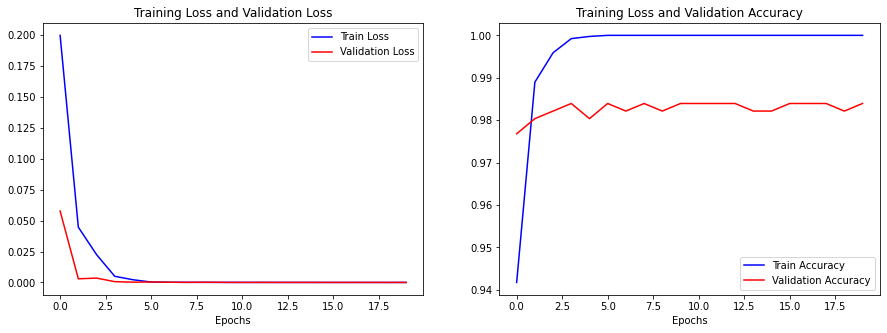

In [ ]:
train_sequential_net(net_v1, epochs, train_loader, valid_loader, criterion, optimizer, counter, clip, 95, 56, True)

Entrenamos `net_v2`:

Epoch 0/19
----------
Train Loss: 0.7080 Acc: 0.1461
Val Loss: 0.7092 Acc: 0.1482
Epoch 1/19
----------
Train Loss: 0.7076 Acc: 0.1484
Val Loss: 0.7070 Acc: 0.1482
Epoch 2/19
----------
Train Loss: 0.7078 Acc: 0.1469
Val Loss: 0.7065 Acc: 0.1482
Epoch 3/19
----------
Train Loss: 0.7080 Acc: 0.1451
Val Loss: 0.7097 Acc: 0.1482
Epoch 4/19
----------
Train Loss: 0.7078 Acc: 0.1466
Val Loss: 0.7099 Acc: 0.1482
Epoch 5/19
----------
Train Loss: 0.7079 Acc: 0.1417
Val Loss: 0.7082 Acc: 0.1482
Epoch 6/19
----------
Train Loss: 0.7077 Acc: 0.1456
Val Loss: 0.7091 Acc: 0.1482
Epoch 7/19
----------
Train Loss: 0.7078 Acc: 0.1463
Val Loss: 0.7084 Acc: 0.1482
Epoch 8/19
----------
Train Loss: 0.7078 Acc: 0.1484
Val Loss: 0.7098 Acc: 0.1482
Epoch 9/19
----------
Train Loss: 0.7076 Acc: 0.1448
Val Loss: 0.7087 Acc: 0.1482
Epoch 10/19
----------
Train Loss: 0.7078 Acc: 0.1443
Val Loss: 0.7094 Acc: 0.1482
Epoch 11/19
----------
Train Loss: 0.7077 Acc: 0.1471
Val Loss: 0.7049 Acc: 0.1482
Epoch 12/19
--

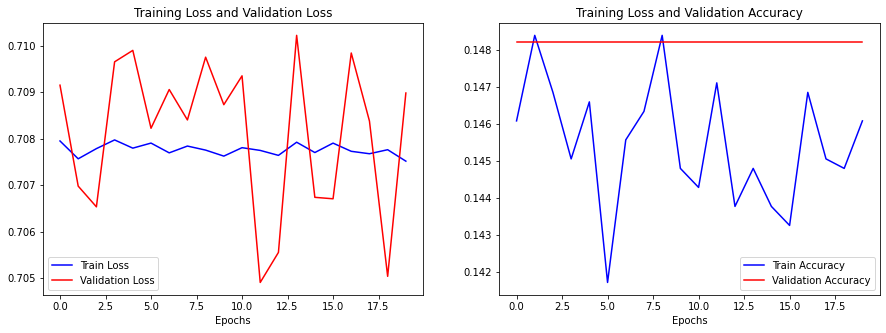

In [ ]:
train_sequential_net(net_v2, epochs, train_loader, valid_loader, criterion, optimizer, counter, clip, 95, 56, True)

Epoch 0/19
----------
Train Loss: 0.7022 Acc: 0.1936
Val Loss: 0.7018 Acc: 0.1482
Epoch 1/19
----------
Train Loss: 0.7022 Acc: 0.1969
Val Loss: 0.7030 Acc: 0.1482
Epoch 2/19
----------
Train Loss: 0.7023 Acc: 0.1869
Val Loss: 0.7014 Acc: 0.1482
Epoch 3/19
----------
Train Loss: 0.7022 Acc: 0.1933
Val Loss: 0.7027 Acc: 0.1482
Epoch 4/19
----------
Train Loss: 0.7020 Acc: 0.1985
Val Loss: 0.7049 Acc: 0.1482
Epoch 5/19
----------
Train Loss: 0.7019 Acc: 0.2031
Val Loss: 0.7013 Acc: 0.1482
Epoch 6/19
----------
Train Loss: 0.7020 Acc: 0.1900
Val Loss: 0.7020 Acc: 0.1482
Epoch 7/19
----------
Train Loss: 0.7019 Acc: 0.1992
Val Loss: 0.7026 Acc: 0.1482
Epoch 8/19
----------
Train Loss: 0.7020 Acc: 0.1964
Val Loss: 0.7021 Acc: 0.1482
Epoch 9/19
----------
Train Loss: 0.7020 Acc: 0.2010
Val Loss: 0.7015 Acc: 0.1482
Epoch 10/19
----------
Train Loss: 0.7021 Acc: 0.1905
Val Loss: 0.7022 Acc: 0.1482
Epoch 11/19
----------
Train Loss: 0.7022 Acc: 0.1895
Val Loss: 0.7026 Acc: 0.1482
Epoch 12/19
--

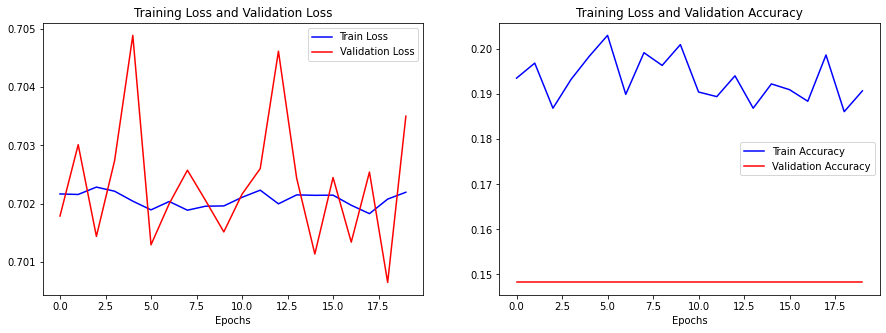

In [ ]:
train_sequential_net(net_v3, epochs, train_loader, valid_loader, criterion, optimizer, counter, clip, 95, 56, True)

### Testing:

Evaluamos los modelos en el set de test.

In [ ]:
def test_model(net, test_loader, test_batch_size, criterion=criterion):
  test_losses = []
  num_correct = 0

  h = net.init_hidden(test_batch_size)
  net.eval()
  for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    if (train_on_gpu):
      inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)
    
    pred = torch.round(output.squeeze())
    num_correct += torch.sum(pred == labels.data)
  test_acc = num_correct.cpu()/len(test_loader.dataset)
  print("Test accuracy: {:.3f}".format(test_acc))

In [ ]:
test_model(net_v1, test_loader, 223)

Test accuracy: 0.983


la version 1 es mucho más precisa, un aumento en los tamaños de los embeddings no se traduce en una mejor comprensión de las plabras. El buen ajuste de este hyperparámetro es primordial, ya que como se puede ver en las pruebas, la variación de este repercute de manera crítica en la calidad de las predicciones. 
Como se mencionó en clases, este hiperparámetro se debe definir para cada caso y no existe una regla general que permita fijar su valor y que sea optimo para todos los casos.